This notebook is all about coming up with ways to asses how good a job PyVBMC does. 

To start, we'll state the differential equation of interest, get integration working for that equation, and run a PyVBMC optimize routine on it.


The differential equation:

$$\ddot{x} = -x -ax^b$$

generalized to deal with all values of b:

$$\ddot{x} = -x - sign(x)a|x|^b$$

$0<a\leq0.5$

 $1\leq b \leq 5$

In [83]:
import pandas as pd  # Data handling
import matplotlib.pyplot as plt # visualization
from scipy.integrate import odeint # numerical integration
import numpy as np
from pyvbmc import VBMC # VMBC object
import scipy.stats as scs # scipy stats to get distributions from
from pyvbmc.priors import UniformBox, Trapezoidal, SplineTrapezoidal, SmoothBox # nice priors from PyVBMC
from sklearn.preprocessing import StandardScaler

In [51]:
def diffyqs(X, t, a,b):
    x, vx = X[0], X[1]
    dx = vx
    dv = -x - np.sign(x) * a * np.abs(x)**b
    return [dx, dv]

initial_condition = [0.0, 3.5]
t = np.arange(0,10,0.05)

a = 0.2 
b = 4.0
sol = odeint(diffyqs, initial_condition, t, args=(a,b))

x_true = sol[:,1]

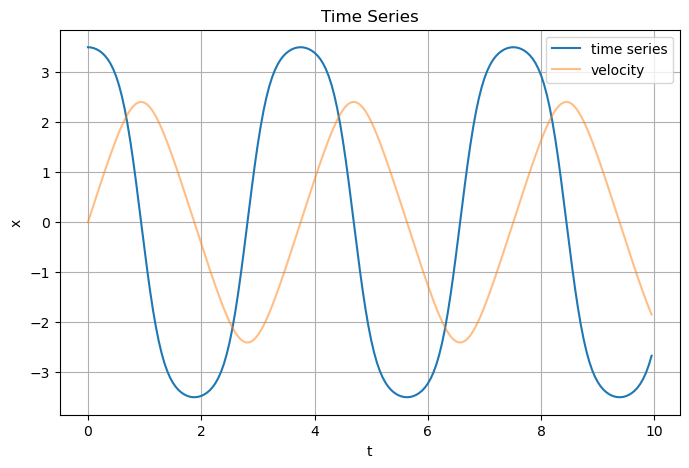

In [52]:
def plot_ts(t,ts,v, mode = 0):
    plt.figure(figsize=(8,5))
    if mode == 0:
        plt.plot(t,ts)
        plt.title('Time Series')
        plt.xlabel('t')
        plt.ylabel('x')
        plt.grid()
        plt.show()
    else:
        plt.plot(t,ts, label = 'time series')
        plt.plot(t,v, label = 'velocity', alpha = 0.5)
        plt.title('Time Series')
        plt.xlabel('t')
        plt.ylabel('x')
        plt.legend()
        plt.grid()
        plt.show()

plot_ts(t,sol[:, 1],sol[:, 0],1)

In [53]:
def log_likelihood(theta):
    a,b = theta

    sol = odeint(diffyqs, initial_condition, t, args=(a,b)) # get solution of ODE with current choice of params
    
    return -np.sum((sol[:,1] - x_true)**2) # normal distribution sorta

In [62]:
D = 2  # 2-D since there are 2 params we're estimating

LB = np.full((1, D), 0.0)  # Lower bounds
LB[0][1] = 1
UB = np.full((1, D), 0.5)  # Upper bounds
UB[0][1] = 5

PLB = np.copy(LB) + 0.1
PUB = np.copy(UB) - 0.1

x0 = np.full((1, D), 0.11) # starting point for inference   # 1.5 * np.ones((1, D))
x0[0][1] = 3.5

print(LB,PLB,PUB,UB,'x0:',x0)

[[0. 1.]] [[0.1 1.1]] [[0.4 4.9]] [[0.5 5. ]] x0: [[0.11 3.5 ]]


In [65]:
prior = SplineTrapezoidal(LB, PLB, PUB, UB)

vbmc = VBMC(log_likelihood, x0, LB, UB, PLB, PUB, prior = prior) # initialize VMBC object

In [66]:
vp, results = vbmc.optimize(); # do optimization (might take a while)

Beginning variational optimization assuming EXACT observations of the log-joint.
 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     0         10          88.44       145.67          inf        2        inf     start warm-up
     1         15          -8.30         0.34        18.40        2        inf     
     2         20          -8.53         0.00         0.04        2       1.72     
     3         25          -8.50         0.00         0.10        2       2.47     
     4         30          -8.44         0.15         4.15        2       98.5     
     5         35          -8.36         0.00         0.18        2       4.46     
     6         40          -8.38         0.00         0.12        2       2.96     end warm-up
     7         45          -8.41         0.00         0.66        2       15.7     
     8         50          -8.38         0.00         0.04        2       1.01     
     9         55          -7.96         0.00    

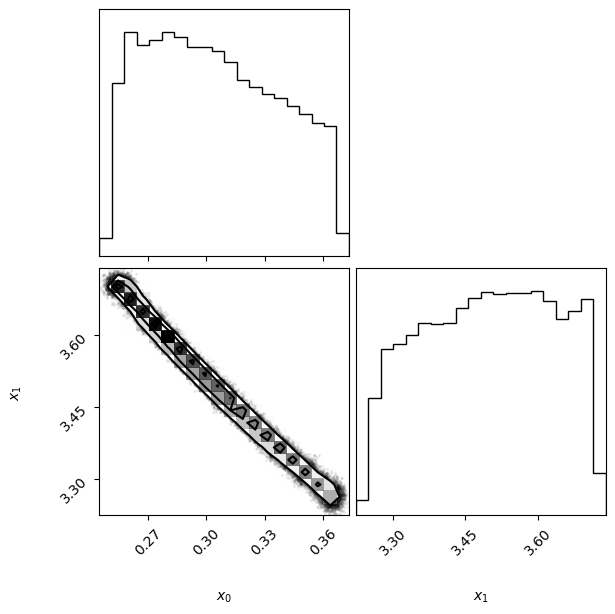

In [67]:
vp.plot();

Now that we have a Variational Posterior, we can think about defining a metric for it.

In [116]:
def euclidean_metric(vp,truth_array, n_samples = int(1e6)): 
    """
    Returns a measure of how close the actual parameters are to the estimated parameters,
    computed by finding the euclidean distance between the mean of a large sample of the 
    varaitional posterior and the true values of the parameters.

    vp: varational posterior from PyVBMC
    truth_array: numpy array of the true values of the parameters (must be in the same order as the vp returns!)
    """
    Xs, _ = vp.sample(n_samples) # sample vp
    scaler = StandardScaler(with_mean = False) # create scaler (don't bother centering)
    scaler.fit(Xs)                     # fit scaler to samples
    scaled_data = scaler.transform(Xs) # scale samples
    mean = np.array([scaled_data[:,0].mean(),scaled_data[:,1].mean()]) # compute mean of samples
    truth_scaled = scaler.transform(truth_array) # scale true data
    return np.linalg.norm(mean-truth_scaled) # return distance between mean and truth

# call the function on our current example
euclidean_metric(vp,np.array([[a,b]]))

5.019125887229127